In [ ]:
# pip install unidecode minio transformers nltk scikit-learn dotenv matplotlib pandas --quiet

In [1]:
from utils_for_colab import try_load
from transformers import pipeline
from dotenv import load_dotenv
from tqdm.notebook import tqdm
from minio import Minio

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import os

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

cuda:0


# 0. Инициализация

In [4]:
load_dotenv()

AWS_ACCESS_KEY_ID_2 = os.getenv('AWS_ACCESS_KEY_ID_2')
AWS_SECRET_ACCESS_KEY_2 = os.getenv('AWS_SECRET_ACCESS_KEY_2')

client_s3 = Minio(
    "storage.yandexcloud.net",
    access_key=AWS_ACCESS_KEY_ID_2,
    secret_key=AWS_SECRET_ACCESS_KEY_2,
    secure=True
)

In [5]:
# Модель классификатор
classifier = pipeline(
    task="zero-shot-classification",
    model="facebook/bart-large-mnli"
    )

Device set to use cuda:0


___Загрузка данных___

In [6]:
# Все оригинальные новости The Guardian
the_guardian_clean_politic_news_03052025 = try_load(
    file_path='/content/',
    file_name='the_guardian_clean_politic_news_03052025.pkl',
    client_s3=client_s3
    )

the_guardian_clean_politic_news_list = list() # Соберем все статьи в список
the_guardian_clean_politic_news_03052025_keys = the_guardian_clean_politic_news_03052025.keys()
for key in the_guardian_clean_politic_news_03052025_keys:
  the_guardian_clean_politic_news_list.append(
      the_guardian_clean_politic_news_03052025[key][1]
  )

# Все оригинальные новости New york Times
papers_nyt_clean = try_load(
    file_path='/content/',
    file_name='papers_nyt_clean.pkl',
    client_s3=client_s3
    )
papers_nyt_clean_list = list(papers_nyt_clean.values()) # Соберем все статьи в список


# Сгененрированные новости New York Times
papers_nyt_rewrite_news = try_load(
    file_path='/content/',
    file_name='papers_nyt_rewrite_news.pkl',
    client_s3=client_s3
    )

papers_nyt_rewrite_news_list = list()
for key, (orig_paper, edit_paper_0, eval_paper_1, edit_paper_1, eval_paper_2, edit_paper_2, eval_paper_3, edit_paper_3) in papers_nyt_rewrite_news.items():
  papers_nyt_rewrite_news_list += [edit_paper_0, edit_paper_1, edit_paper_2, edit_paper_3]


# Сгенерированные новости Deepseek v3 (длинная версия)
deepseek_write_long_papers = try_load(
    file_path='/content/',
    file_name='deepseek_write_long_papers.pkl',
    client_s3=client_s3
    )

deepseek_write_long_papers_list = list()
for key, items in deepseek_write_long_papers.items():
  deepseek_write_long_papers_list += [items[0], items[1]] # Соберем все статьи в список

# Сгенерированные новости Deepseek v3 (короткая версия)
deepseek_write_papers = try_load(
    file_path='/content/',
    file_name='deepseek_write_papers.pkl',
    client_s3=client_s3
    )

deepseek_write_papers_list = list()
for key, (paper_for_update, eval_paper, final_paper) in deepseek_write_papers.items():
  deepseek_write_papers_list += [paper_for_update, final_paper] # Соберем все статьи в список

# Переписанные новотсти The Guardian
dsv3_cycle_rewrite_from_orig = try_load(
    file_path='/content/',
    file_name='dsv3_cycle_rewrite_from_orig.pkl',
    client_s3=client_s3
    )

dsv3_cycle_rewrite_from_orig_list = list()
for key, (orig_paper, edit_paper_0, eval_paper_1, edit_paper_1, eval_paper_2, 
          edit_paper_2, eval_paper_3, edit_paper_3, edit_paper_4, edit_paper_5) in dsv3_cycle_rewrite_from_orig.items():
  dsv3_cycle_rewrite_from_orig_list += [
    edit_paper_0, edit_paper_1, edit_paper_2, edit_paper_3, edit_paper_4, edit_paper_5
    ]  # Соберем все статьи в список

# 1. Подготовка данных

In [30]:
# Соберем оригинальные и сгенерированные данные
list_orig_news = the_guardian_clean_politic_news_list + papers_nyt_clean_list
list_gen_news = papers_nyt_rewrite_news_list + deepseek_write_long_papers_list + deepseek_write_papers_list + dsv3_cycle_rewrite_from_orig_list

# Удалим переносы строк 
for i, paper in enumerate(list_orig_news):
  list_orig_news[i] = paper.replace('\n', ' ')

for i, paper in enumerate(list_gen_news):
  list_gen_news[i] = paper.replace('\n', ' ')
  
print(f'Len of list orig news = {len(list_orig_news)}')
print(f'Len of list gen news = {len(list_gen_news)}')

Len of list orig news = 7442
Len of list gen news = 4456


In [37]:
# Удаление коротких сгенерированных текстов
del_papers = set()
for i in range(len(list_gen_news)):
    if len(list_gen_news[i].split())<150:
        del_papers.add(i)

list_gen_news_clear = []
for i in range(len(list_gen_news)):
    if i not in del_papers:
        list_gen_news_clear.append(list_gen_news[i])
        
# Уравняем кол-во объектов по класссам
list_gen_news_tets = np.random.choice(list_gen_news_clear, size=3600, replace=False)
list_gen_news_tets = list_gen_news_tets.tolist()

list_orig_news_tets = np.random.choice(list_orig_news, size=len(list_gen_news_tets), replace=False)
list_orig_news_tets = list_orig_news_tets.tolist()

print(f'Len of list orig news = {len(list_orig_news_tets)}')
print(f'Len of list gen news = {len(list_gen_news_tets)}')

Len of list orig news = 3600
Len of list gen news = 3600


# 2. Бейзлайн: zero-shot-classification

facebook/bart-large-mnli

In [38]:
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score
)

In [44]:
def process_batch(texts, true_label, candidate_labels, hypothesis_template):
    """ Обработка текстов AI моделью

    texts               : Список текстов для классификации.
    true_label          : Метка истинного класса (0 для human-written, 1 для AI-generated).
    candidate_labels    : Список меток классов, например: ['AI-generated', 'Human-written'].
    hypothesis_template : Шаблон гипотезы для zero-shot классификации, например: "This text was {}."

    Return              : Список словарей с текстом, оценкой вероятности, и истинной меткой.
    """
        
    results = []
    outputs = classifier(
        texts,
        candidate_labels,
        hypothesis_template=hypothesis_template,
        batch_size=64
    )
    for text, out in zip(texts, outputs):
        
        ai_score = out["scores"][out["labels"].index("AI-generated")]

        results.append({
            "text": text,
            "score": ai_score,
            "ai_paper_flg": true_label
        })
    return results

In [ ]:
# Метки и шаблон
candidate_labels = ['AI-generated', 'Human-written']
hypothesis_template = "This newspaper was {}."

batch_size = 64
results = []

# Обработка human-written
for i in tqdm(range(0, len(list_orig_news_tets), batch_size), desc="Human-written"):
    batch = list_orig_news_tets[i:i+batch_size]
    results.extend(process_batch(batch, true_label=0, candidate_labels=candidate_labels, hypothesis_template=hypothesis_template))

# Обработка AI-generated
for i in tqdm(range(0, len(list_gen_news_clear), batch_size), desc="AI-generated"):
    batch = list_gen_news_clear[i:i+batch_size]
    results.extend(process_batch(batch, true_label=1, candidate_labels=candidate_labels, hypothesis_template=hypothesis_template))

# В DataFrame
result_df = pd.DataFrame(results)
result_df['y_pred'] = result_df['score'].apply(lambda x: 1 if x >= 0.5 else 0)

result_df.head()

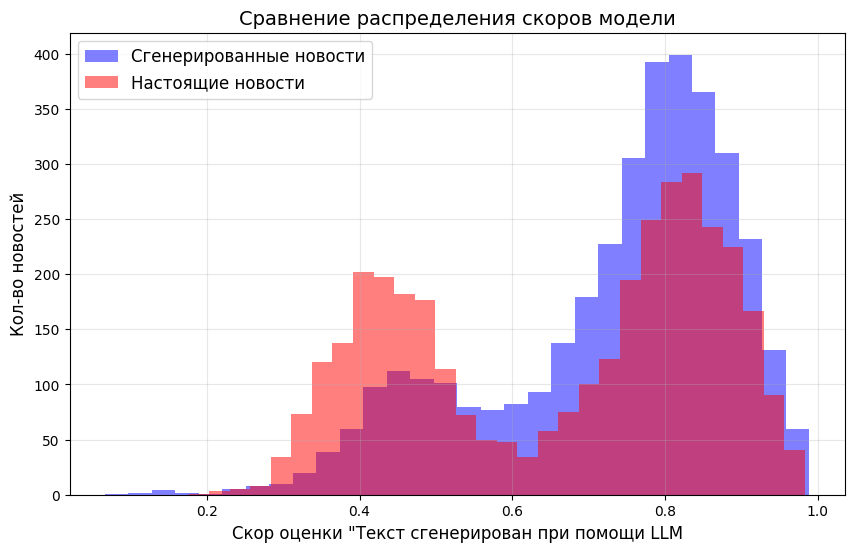

In [46]:
# Гистаграмма распределения скоро
plt.figure(figsize=(10, 6))

result_df[result_df['ai_paper_flg']==1]['score'].hist(bins=30,
                               alpha=0.5,
                               color='blue',
                               label='Сгенерированные новости')

result_df[result_df['ai_paper_flg']==0]['score'].hist(bins=30,
                                 alpha=0.5,
                                 color='red',
                                 label='Настоящие новости')

plt.title('Сравнение распределения скоров модели', fontsize=14)
plt.xlabel('Скор оценки "Текст сгенерирован при помощи LLM', fontsize=12)
plt.ylabel('Кол-во новостей', fontsize=12)

plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.show()

In [65]:
print("ROC-AUC:", roc_auc_score(result_df['ai_paper_flg'], result_df['score']))
print("Average_precision_score:", average_precision_score(result_df['ai_paper_flg'], result_df['score']), '\n')

print("Precision:", precision_score(result_df['ai_paper_flg'], result_df['y_pred']))
print("Recall:", recall_score(result_df['ai_paper_flg'], result_df['y_pred']))
print("F1-score:", f1_score(result_df['ai_paper_flg'], result_df['y_pred']))

ROC-AUC: 0.588429081913139
Average_precision_score: 0.5571965022606704 

Precision: 0.5630117479530082
Recall: 0.8694337548103354
F1-score: 0.6834485738980121
